In [1]:
from calibrate import Calibrate

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
%matplotlib inline



In [2]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_images = "output_images/"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibrate = Calibrate(images, nx, ny)
print("Calibration Complete")

Calibration Complete


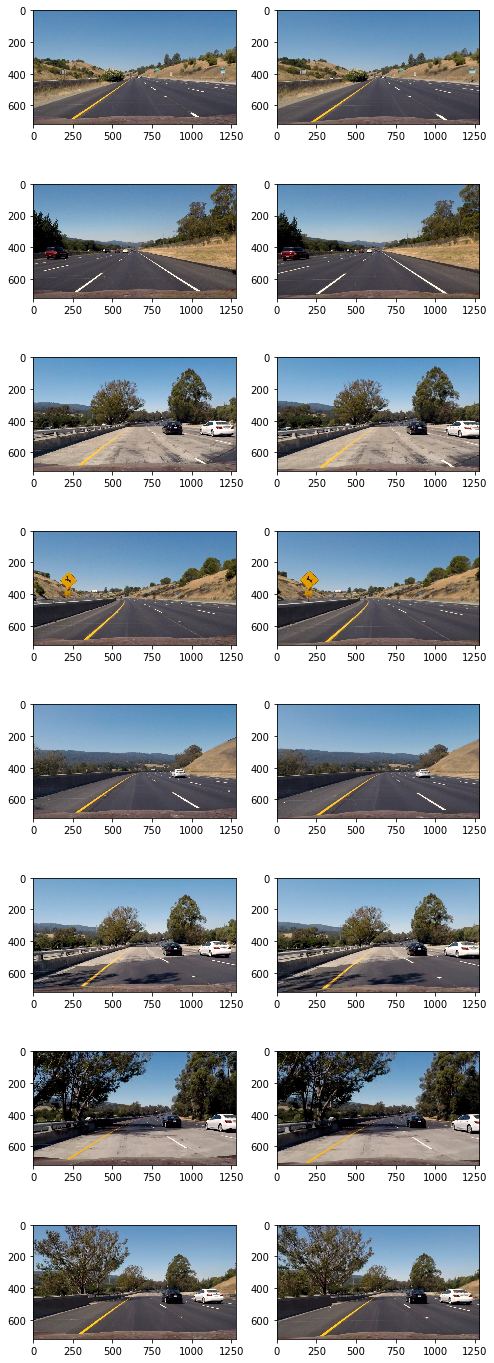

In [4]:
images = glob.glob('./test_images/*.jpg')
undistorted_images = "undistorted_images"
if not os.path.exists(output_images+undistorted_images):
    os.makedirs(output_images+undistorted_images)
undistorted_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    undistorted_img = calibrate.undistort(img)
    output_fname = output_images+undistorted_images+images[i].split("\\")[-1]
    cv2.imwrite(output_fname, cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(undistorted_img)
plt.show()

In [25]:
import thresholdutil as tu
def threshold_pipeline(img):
    mag_binary = tu.mag_thresh(img, mag_thresh=(70, 255))
    dir_binary = tu.dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    sx_binary = tu.abs_sobel_thresh(img, thresh=(70, 255))
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_binary = tu.binary_threshold(hls_img[:,:,2], thresh=(200,255))
    
    res_bin = np.zeros_like(dir_binary)
    res_bin[(dir_binary==1) & (mag_binary==1)] = 1
    res_bin[(hls_binary==1) | (sx_binary==1)] = 1
    
    return res_bin

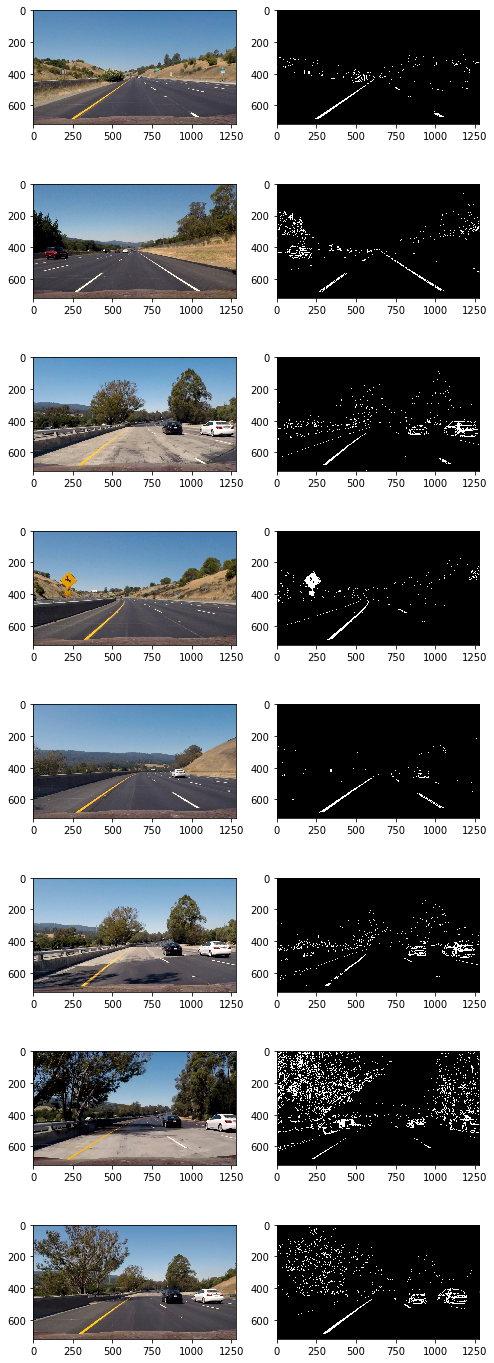

In [26]:

images = glob.glob('./test_images/*.jpg')
thresholded_images = "thresholded_images"
if not os.path.exists(output_images+thresholded_images):
    os.makedirs(output_images+thresholded_images)
thresholded_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+thresholded_images+images[i].split("\\")[-1]
    
    res_bin = threshold_pipeline(img)
    output_img = np.dstack((res_bin, res_bin, res_bin))*255
    
    cv2.imwrite(output_fname, output_img)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(output_img)
plt.show()

In [ ]:
def perspective_transform(img):
    

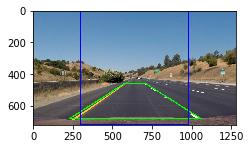

In [12]:
xy_bl = (230, 680)
xy_tl = (575, 460)
xy_tr = (710, 460)
xy_br = (1060, 680)
src_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])

xy_bl = (300, 719)
xy_tl = (300, 0)
xy_tr = (980, 0)
xy_br = (980, 719)
dst_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])
images = ['./test_images/straight_lines1.jpg']
#images = glob.glob('./test_images/*.jpg')
perspective_images = "perspective_images"
if not os.path.exists(output_images+perspective_images):
    os.makedirs(output_images+perspective_images)
perspective_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+perspective_images+images[i].split("\\")[-1]
    
    
    cv2.polylines(img,src_pts,True,(0,255,0),thickness=5)
    cv2.polylines(img,dst_pts,True,(0,0,255),thickness=5)
    
    #cv2.imwrite(output_fname, output_img)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)

plt.show()